In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import sympy as sp

0.0


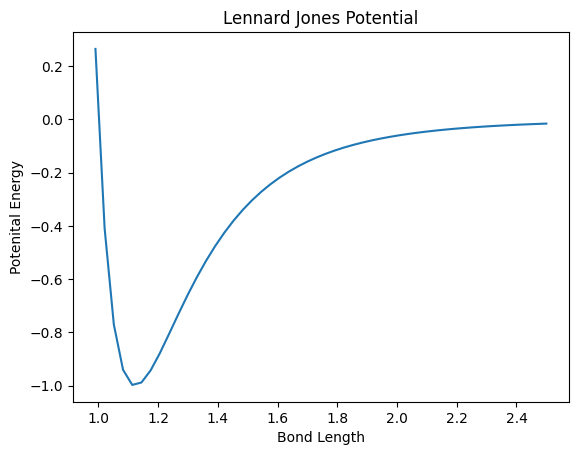

In [8]:
def r_mag(atom_1, atom_2):
    norm_1 = np.linalg.norm(atom_1)
    norm_2 = np.linalg.norm(atom_2)
    r = np.sqrt((norm_2 - norm_1)**2)
    return r

def Vlj_3d(r_mag, epsilon=1.0, sigma=1.0):
    potential = 4*epsilon*((sigma/r_mag)**12 - (sigma/r_mag)**6)
    return potential

A = np.array([1.0, 0.0, 0.0]) 
B = np.array([0.0, 0.0, 0.0])
atoms = [A,B]
r = r_mag(atoms[0], atoms[1])
    
print(Vlj_3d(r)) #This here is for a single point, but lets sketch out this potential for mulitple radii
radii = np.linspace(0.99,2.5)
V_E = Vlj_3d(radii)
plt.plot(radii, V_E);plt.xlabel("Bond Length");plt.ylabel("Potenital Energy");plt.title("Lennard Jones Potential")
plt.show()

In [54]:
def Flj_3d(atom, atoms, epsilon=1.0, sigma=1.0):
    force = np.zeros((3,1))
    for i in range(len(atoms)):
        force_part = np.zeros((3,1))
        r = r_mag(atom, atoms[i])
        if r != 0:
            for j in range(3):
                force_part[j] = ((atom[j] - atoms[i][j]) * ((24*sigma*(epsilon**6)) / (r**8))
                *(1-(2*((sigma/r)**6))))
            force -= force_part
    return force #Our force is 3 dimensional
    
A = np.array([1.0, 0.0, 0.0]) 
B = np.array([0.0, 0.0, 0.0])
atoms = [A,B]
F = Flj_3d(atoms[0], atoms)

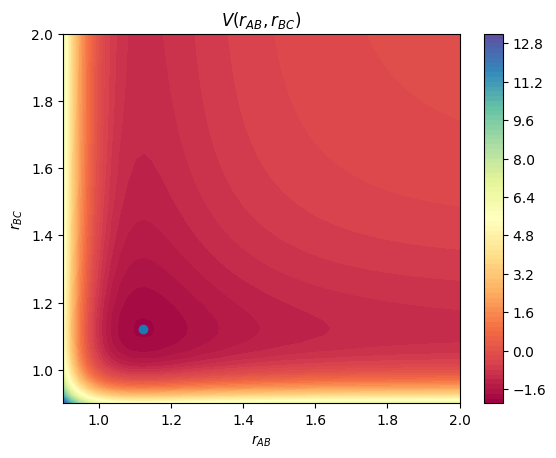

In [20]:
r_AB = np.linspace(0.9,2.0)
r_BC = np.linspace(0.9,2.0)

def V(r, epsilon=1, sigma=1):
    potential = 4*epsilon*((sigma/r)**12 - (sigma/r)**6)
    return potential


rAB, rBC,= np.meshgrid(r_AB, r_BC)
    
V_AB_BC = V(rAB) + V(rBC) + V(rAB + rBC)

plt.contourf(rAB, rBC, V_AB_BC, levels=100, cmap='Spectral')
plt.colorbar()
r_min = 2**(1/6)
plt.scatter(r_min,r_min)

plt.title('$V(r_{AB}, r_{BC})$')
plt.xlabel('$r_{AB}$')
plt.ylabel('$r_{BC}$')
plt.show()

In [19]:
def bond_lengths(pos):
    r = [[0 for _ in range(len(pos))] for _ in range(len(pos))]
    for i in range(len(pos)):
        for j in range(len(pos)):
            xij = pos[i][0][-1] - pos[j][0][-1]
            yij = pos[i][1][-1] - pos[j][1][-1]
            zij = pos[i][2][-1] - pos[j][2][-1]
            r[i][j] = np.sqrt(xij**2 + yij**2 + zij**2)
    return r    

def lj_3d(particle_index, pos, r, sigma=1.0, epsilon=1.0):
    #The force vector containing all 3D forces acting on a specified particle.
    f = [0, 0, 0]
    for i in range(len(pos)):
        if i != particle_index:
            f[0] = (0.5)*(pos[particle_index][0][-1] - pos[i][0][-1])*((24*epsilon*(sigma**6))/(r[particle_index][i]**8))*(1 - 2*((sigma/r[particle_index][i])**6))
            f[1] = (0.5)*(pos[particle_index][1][-1] - pos[i][1][-1])*((24*epsilon*(sigma**6))/(r[particle_index][i]**8))*(1 - 2*((sigma/r[particle_index][i])**6))
            f[2] = (0.5)*(pos[particle_index][2][-1] - pos[i][2][-1])*((24*epsilon*(sigma**6))/(r[particle_index][i]**8))*(1 - 2*((sigma/r[particle_index][i])**6)) 
    return f

def multiple_atoms_Verlet(pos, vel, h, end_time, m):
    t = [0]
    while t[-1] < end_time:
        F = [[0 for _ in range(3)] for _ in range(len(pos))]
        F_new = [[0 for _ in range(3)] for _ in range(len(pos))]
        #Compute all of our r_ij b/c we need them for computing F
        
        r = bond_lengths(pos)
        for i in range(len(pos)):
            F[i] = lj_3d(i, pos, r)
        
        for i in range(len(pos)):
            # step 1: calculate
            pos[i][0].append(pos[i][0][-1] + (h*vel[i][0][-1]) + (((h**2)*F[i][0])/(2*m[i]))) # xi(k+1)
            pos[i][1].append(pos[i][1][-1] + (h*vel[i][1][-1]) + (((h**2)*F[i][1])/(2*m[i]))) # yi(k+1)
            pos[i][2].append(pos[i][2][-1] + (h*vel[i][2][-1]) + (((h**2)*F[i][2])/(2*m[i]))) # zi(k+1)

        # step 2: evaluate  
        # Because we have computed new positions for each particle, we must re-compute our new bond lengths.
        r = bond_lengths(pos)
        for i in range(len(pos)):
            F_new[i] = lj_3d(i, pos, r)
            
        # step 3: calculate
        for i in range(len(pos)):
            vel[i][0].append(vel[i][0][-1] + ((h/(2*m[i])) * (F[i][0] + F_new[i][0])))
            vel[i][1].append(vel[i][1][-1] + ((h/(2*m[i])) * (F[i][1] + F_new[i][1])))
            vel[i][2].append(vel[i][2][-1] + ((h/(2*m[i])) * (F[i][2] + F_new[i][2])))
        t.append(t[-1] + h)
    return t, pos, vel

# def multiple_atoms_Verlet(pos, vel, h, end_time, m):
A = [[-3.0], [0.0], [0.0]] 
B = [[0.0], [0.0], [0.0]]#format particle name = [[x], [y], [z]]
C = [[1.3], [0.0], [0.0]]
pos = [A, B, C]
A_v = [[1.0], [0.0], [0.0]]
B_v = [[0.0], [0.0], [0.0]] #format {particle name}_v  = [[v_x], [v_y], [v_z]]
C_v = [[0.0], [0.0], [0.0]]
vel = [A_v, B_v, C_v]
h = 0.02
m = [1, 1, 1]
end_time = 4
t, pos, vel = multiple_atoms_Verlet(pos, vel, h, end_time, m)

# Converting lists into arrays to make math easier.
A = np.array(pos[0][0])
B = np.array(pos[1][0])
C = np.array(pos[2][0])
vel = np.array(vel)

r_AB_x = np.abs(A-B)
r_BC_x = np.abs(B-C)
r_AC_x = np.abs(A-C)

print(lj_3D())
#plt.plot(r_AB_x, r_BC_x);plt.show()

NameError: name 'lj_3D' is not defined